In [1]:
import sys, os
sys.path.append("lib") # adding "lib" path with own packages
from Sigma_mol import sigma_mol # reads the radio sounsing and compute extinction coefficient
from scipy.interpolate import interp1d # to interpolate modeled variables to lidar heights
from lidar_integrating_space_time import Lidar_space_time as lidar_integ #integrates lidar raw data in height and time
from lidar_integrating_space_time_std import Lidar_space_time2 as lidar_integ_std #maybe not used
from fft_denoising import fft_denoising #maybe not used
from klett import Klett81b #maybe not used
import numpy as np 
import pylab #plots
from DP_simp import DP_simp # Curve simplification
from running_mean import running_mean # runing mean
from time2epoch import time2epoch #maybe not used?
#from cloud_mask_v1 import cloud_mask
from netCDF4 import Dataset 
#from time import sleep
from scipy import stats
from scipy.optimize import curve_fit
from dplots import densplot # make 2D desity plots
from Comb_LidarMRR import Comb_LidarMRR3 as Comb_LidarMRR 
from cloud_mask_v2 import cloud_mask2
from sm_paramTOP import sm_paramTOP
import matplotlib
from copy import copy
from BG_corr import BG_corr
import time

In [31]:
np.min(r_sm),r[9]

(0.11, 0.11068899881814716)

C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\duran\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


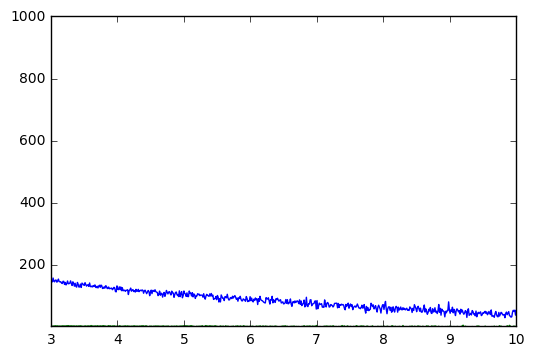

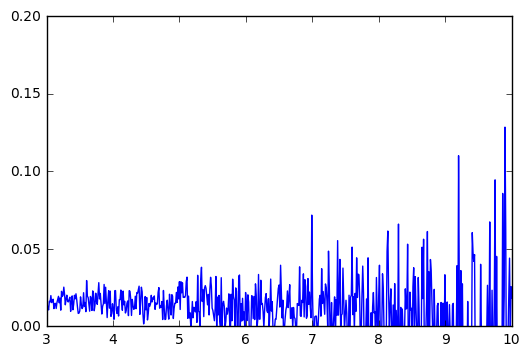

0.289267654586


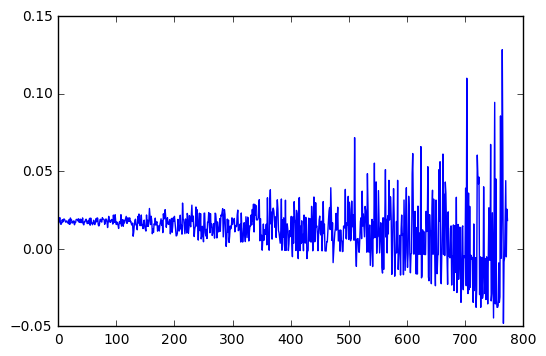

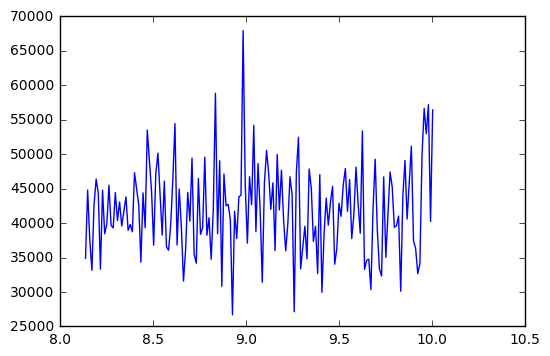

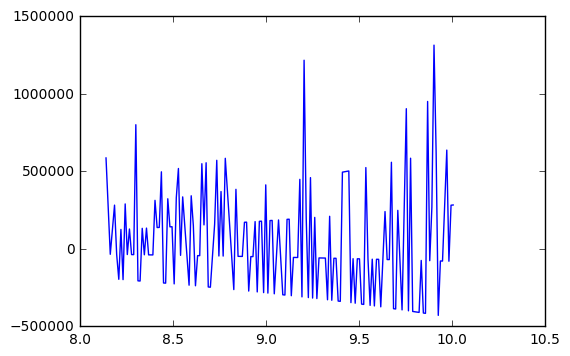

Cpar =  41974.6973289 /std =  6517.44090938 Cper =  48700.0724658 /std =  331803.357907 Cpar/Cper =  0.861902153397


In [75]:
TRES = 5
VRES = 3

year = 2017
month = 5
day = 25
hour = 14

#2017/02/25
#2017/03/08
#2017/03/13
#2017/03/15
#2017/03/18


path_in = "I:/PHD/Lidar/Processing_V3/Signals/"+str(TRES)+"min"+str(VRES)+"bins/"
filename1 = path_in+"Par90_bc/Par90bc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"
filename3 = path_in+"Per_bc/Perbc_"+str(year)+str(month).zfill(2)+str(day).zfill(2)+"_"+str(TRES)+"min_"+str(VRES)+"bins.dat"

r   = np.loadtxt(path_in+"R_"+str(TRES)+"min_"+str(VRES)+"bins.dat")
Mat_Spar = np.loadtxt(filename1)
Mat_Sper = np.loadtxt(filename3)

Spar = Mat_Spar[(60./TRES)*hour,:]
Sper = Mat_Sper[(60./TRES)*hour,:]

pylab.plot(r[:],Spar)
pylab.plot(r[:],Sper)
pylab.axis([3,10,1,1000])
pylab.show()

pylab.plot(r[:],((Sper))/(Spar))
pylab.axis([3,10,0,0.2])
pylab.show()

pylab.plot((Sper/Spar)[100:])
print 0.00366/np.mean(((Sper)/(Spar))[100:])
pylab.show()

r_sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[2]
sm = BG_corr(Spar,r, year, month, day,rcf0 = 8)[3]

f_sm = interp1d(r_sm, sm)

sm_lidar = f_sm(r[10:])
bm = f_sm(r[10:])/((8*np.pi/3)*1.0401)
bm_par = 0.996*bm
bm_per =0.00366*bm_par
T2 = np.exp((-2*np.cumsum(sm_lidar)*(r[1]-r[0])))  

Cpar_ = Spar[10:]/(bm_par*T2)
Cper_ = Sper[10:]/(bm_per*T2)

pylab.plot(r[10:][700:],Cpar_[700:])
pylab.show()

pylab.plot(r[10:][700:],Cper_[700:])
pylab.show()

Cpar = np.nanmean(Cpar_[700:])
Cper = np.nanmean(Cper_[700:])
Cpar_std = np.nanstd(Cpar_[700:])
Cper_std = np.nanstd(Cper_[700:])

print "Cpar = ", Cpar,'/std = ',Cpar_std,"Cper = ",Cper,'/std = ',Cper_std,"Cpar/Cper = ", Cpar/Cper

In [66]:
1515847.62461/1514304.70146

1.0010188987384854